# [LAB-13] 3. 통계적 시계열 데이터 분석(ARIMA)에 필요한 파라미터(p, d, q)값 추정하기

파이썬 코드에서 겁나 길어서 줄바꿈 하고 싶을때:

해당 코드를 ()로 감싸주면 줄바꿈 자유로워짐

## #01. 준비작업

### 1. 라이브러리 가져오기

In [10]:
# 0. 기본 참조:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb

# 1. 탐색적 데이터 분석: 시계열분해 패키지:
from statsmodels.tsa.seasonal import seasonal_decompose

# 2. 데이터 전처리: ADF Test - 정상성(평균 일정) 확인용:
from statsmodels.tsa.stattools import adfuller
# 2. 데이터 전처리: ACF, PACF 테스트용:
from statsmodels.tsa.stattools import acf, pacf
# 2. 데이터 전처리: ACF, PACF 시각화용:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 2. 그래프 초기화

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기

In [3]:
origin = load_data('air_passengers')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (144, 2)
열 갯수: 2
행 갯수: 144

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### 4. 데이터 전처리 (차분, d)

===== [차분결과표] =====


,차수,ADF Statistic,p-value,num of lags,num of observations,정상성(stationarity)
0,0,0.815369,9.918802e-01,13,130,False
1,1,-2.829267,5.421329e-02,12,130,False
2,2,-16.384232,2.732892e-29,11,130,True


===== [차분된 데이터] =====


,Passengers
Month,
1949-03-01,8.0
1949-04-01,-17.0
1949-05-01,-5.0
1949-06-01,22.0
1949-07-01,-1.0


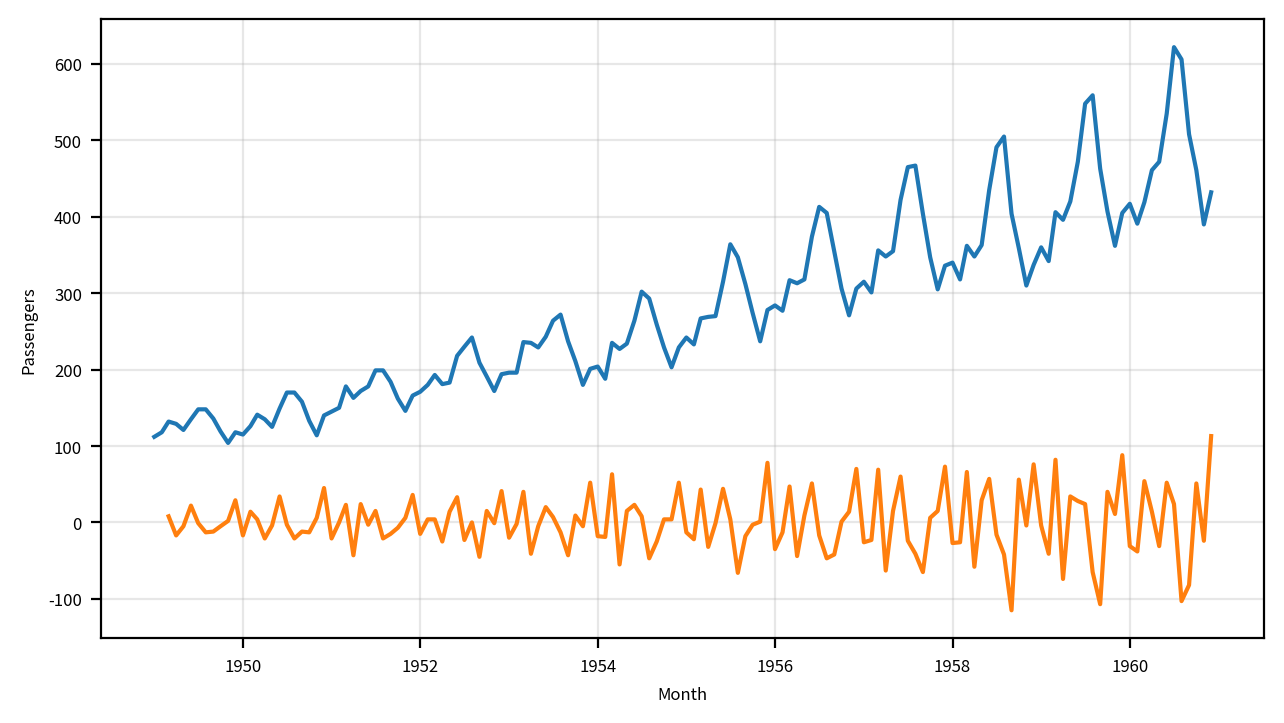

In [7]:
# 1. 시계열 데이터 전처리
# (1) 인덱스 설정:
df1 = origin.set_index('Month') # : 원본 시계열 데이터

# (2) "차분(Difference) + 시각화 + ADF test" 수행:
diff_df = df1.copy()
yname = 'Passengers'
diff_count = 0  # 반복문용 차분 회차 초기값
result = [] # 결과 저장용 빈 리스트

while True:
    # ADF test 실시:
    ar = adfuller(diff_df[yname])
    ar_dict = {
        '차수': diff_count,
        'ADF Statistic': ar[0],
        'p-value': ar[1],
        'num of lags': ar[2],
        'num of observations': ar[3],
        '정상성(stationarity)': True if ar[1] <= 0.05 else False
    }

    # 리스트에 정상성 검사결과 저장:
    result.append(ar_dict)

    # 정상성(평균 일정) 충족 시 반복중단:
    if ar[1] <= 0.05:
        break

    # 정상성(평균 일정) 미충족 시 수행 차분 추가:
    diff_count = diff_count + 1
    diff_df = diff_df.diff().dropna()

# 차분결과표 출력:
print("===== [차분결과표] =====")
display(DataFrame(result))

# 차분 처리한 데이터 출력:
print("===== [차분된 데이터] =====")
display(diff_df.head())

# 시계열 그래프 시각화 (생략가능):    
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

sb.lineplot(data = df1, x = df1.index, y = yname)
sb.lineplot(data = diff_df, x = diff_df.index, y = yname)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

## #02. ACF (AutoCorrelation Function, 자기상관함수) 검정 - MA(q) 찾는 프로세스

### 1. ACF 직접 계산하기 

#### 1) 수치값 확인:

In [12]:
# 1. 차분된 시계열의 자기상관계수(ACF) 계산 (lag=0 부터 시작)
acf_vals = acf(diff_df['Passengers'])

# 2. ACF 유의성 판단기준 (ci: 95%)
threshold = 2 / np.sqrt(len(diff_df['Passengers']))

# 3. 임계값을 초과하는(=유의한) lag의 인덱스 추출
significant_lags = np.where(np.abs(acf_vals) > threshold)[0]

# 4. 결과 확인
acf_vals, threshold, significant_lags

(array([ 1.        , -0.19100587, -0.19598169, -0.0485473 , -0.20664662,
         0.11939696,  0.02575129,  0.14558204, -0.22613908,  0.01407533,
        -0.2082756 , -0.12089977,  0.78224898, -0.09592873, -0.19547382,
        -0.07034343, -0.14794844,  0.11319557,  0.01921939,  0.13695131,
        -0.24015233,  0.02613065]),
 np.float64(0.16783627165933782),
 array([ 0,  1,  2,  4,  8, 10, 12, 14, 20]))

#### 2) 결과표 생성

In [13]:
# 1. ACF 계산
acf_vals = acf(diff_df['Passengers'])
threshold = 2 / np.sqrt(len(diff_df['Passengers']))

# 2. 결과표 생성
df_acf = DataFrame({
    "lag": np.arange(len(acf_vals)),
    "acf": acf_vals
})

# 3. 유의성 판단 추가
df_acf['abs_acf'] = df_acf["acf"].abs()
df_acf['significant'] = df_acf["abs_acf"] > threshold

# 4. 이쁘게 정리
df_acf['acf'] = df_acf['acf'].round(3)
df_acf['abs_acf'] = df_acf['abs_acf'].round(3)
df_acf['threshold'] = round(threshold, 3)

# 5. lag=0 제외 (for 판정)
df_acf_result = df_acf.query("lag > 0").reset_index(drop=True)

# 6. 연속유의구간 계산 추가
df_acf_result["prev_significant"] = df_acf_result['significant'].shift(1)

df_acf_result["cut_candidate"] = (
    (df_acf_result["prev_significant"] == True) &
    (df_acf_result['significant'] == False)
)

df_acf_result[['lag', 'acf', 'significant', 'cut_candidate']]

df_acf_result


,lag,acf,abs_acf,significant,threshold,prev_significant,cut_candidate
0,1,-0.191,0.191,True,0.168,NaN,False
1,2,-0.196,0.196,True,0.168,True,False
2,3,-0.049,0.049,False,0.168,True,True
3,4,-0.207,0.207,True,0.168,False,False
4,5,0.119,0.119,False,0.168,True,True
5,6,0.026,0.026,False,0.168,False,False
6,7,0.146,0.146,False,0.168,False,False
7,8,-0.226,0.226,True,0.168,False,False
8,9,0.014,0.014,False,0.168,True,True
9,10,-0.208,0.208,True,0.168,False,False


#### 3) 결과표 판정

### 2. ACF Plot

#### 1) q 후보 추정 (연속 유의구간의 마지막 lag)

In [14]:
q_candidate = (
    df_acf_result
    .loc[df_acf_result['cut_candidate'], 'lag']
    .min() - 1
)

q_candidate

np.int64(2)

#### 2) ACF Plot 시각화: plot_acf()

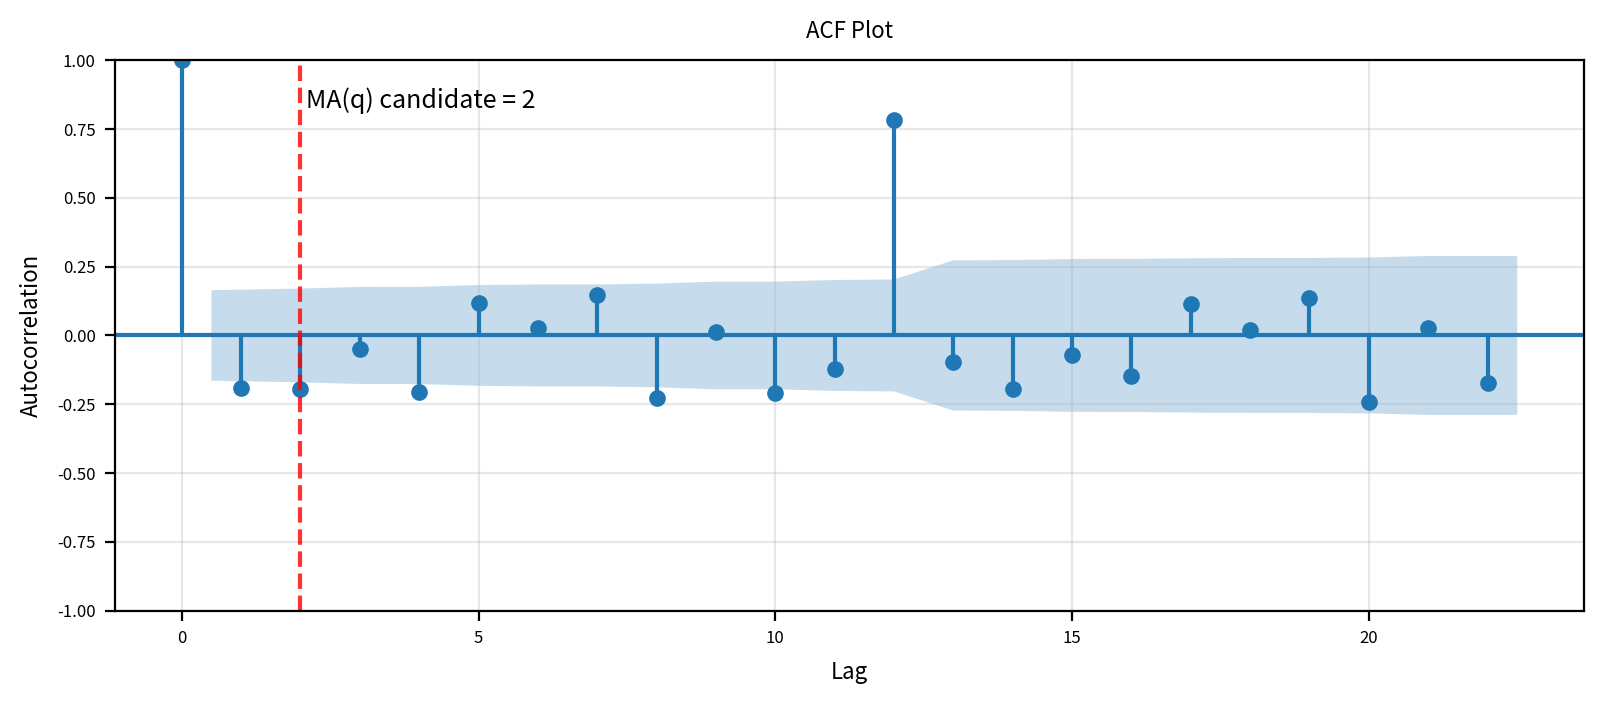

In [16]:
# 1. 그래프 초기화
width_px = 1600
height_px = 700
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2-1. ACF plot 그리기 (ax 파라미터 필수!!)
plot_acf(diff_df['Passengers'], ax=ax)

# 2-2. 추정 MA(q) 시각화
ax.axvline(
    x = q_candidate,
    linestyle = "--",
    linewidth = 1.5,
    alpha = 0.8,
    color = 'red'
)

ax.text(
    q_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"MA(q) candidate = {q_candidate}",
    fontsize = 9,
    verticalalignment = 'top'
)

# 3. 꾸미기
ax.set_title("ACF Plot", fontsize=8, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)    # 배경 격자

# 4. 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프화면 출력
plt.close()                 # 그래프작업 종료

## #03. PACF (Partial ACF, 부분자기상관함수) 검정 - AR(p) 찾는 프로세스

### 1. PACF 직접 계산하기

#### 1) 결과표 생성

In [17]:
# 1. PACF 계산
pacf_vals = pacf(diff_df['Passengers'])
threshold = 2 / np.sqrt(len(diff_df['Passengers']))

# 2. 결과표 생성
df_pacf = DataFrame({
    "lag": np.arange(len(pacf_vals)),
    "pacf": pacf_vals
})

# 3. 유의성 판단 추가
df_pacf['abs_pacf'] = df_pacf["pacf"].abs()
df_pacf['significant'] = df_pacf["abs_pacf"] > threshold

# 4. 이쁘게 정리
df_pacf['pacf'] = df_pacf['pacf'].round(3)
df_pacf['abs_pacf'] = df_pacf['abs_pacf'].round(3)
df_pacf['threshold'] = round(threshold, 3)

# 5. lag=0 제외 (for 판정)
df_pacf_result = df_pacf.query("lag > 0").reset_index(drop=True)

# 6. 연속유의구간 계산 추가
df_pacf_result["prev_significant"] = df_pacf_result['significant'].shift(1)

df_pacf_result["cut_candidate"] = (
    (df_pacf_result["prev_significant"] == True) &
    (df_pacf_result['significant'] == False)
)

df_pacf_result[['lag', 'pacf', 'significant', 'cut_candidate']]

df_pacf_result


,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,-0.192,0.192,True,0.168,NaN,False
1,2,-0.245,0.245,True,0.168,True,False
2,3,-0.159,0.159,False,0.168,True,True
3,4,-0.355,0.355,True,0.168,False,False
4,5,-0.112,0.112,False,0.168,True,True
5,6,-0.169,0.169,True,0.168,False,False
6,7,0.078,0.078,False,0.168,True,True
7,8,-0.329,0.329,True,0.168,False,False
8,9,-0.075,0.075,False,0.168,True,True
9,10,-0.596,0.596,True,0.168,False,False


#### 2) 결과표 판정

### 2. PACF Plot

#### 1) p 후보 추정 (연속 유의구간의 마지막 lag)

In [18]:
p_candidate = (
    df_pacf_result
    .loc[df_pacf_result['cut_candidate'], 'lag']
    .min() - 1
)

p_candidate

np.int64(2)

#### 1) PACF Plot 시각화

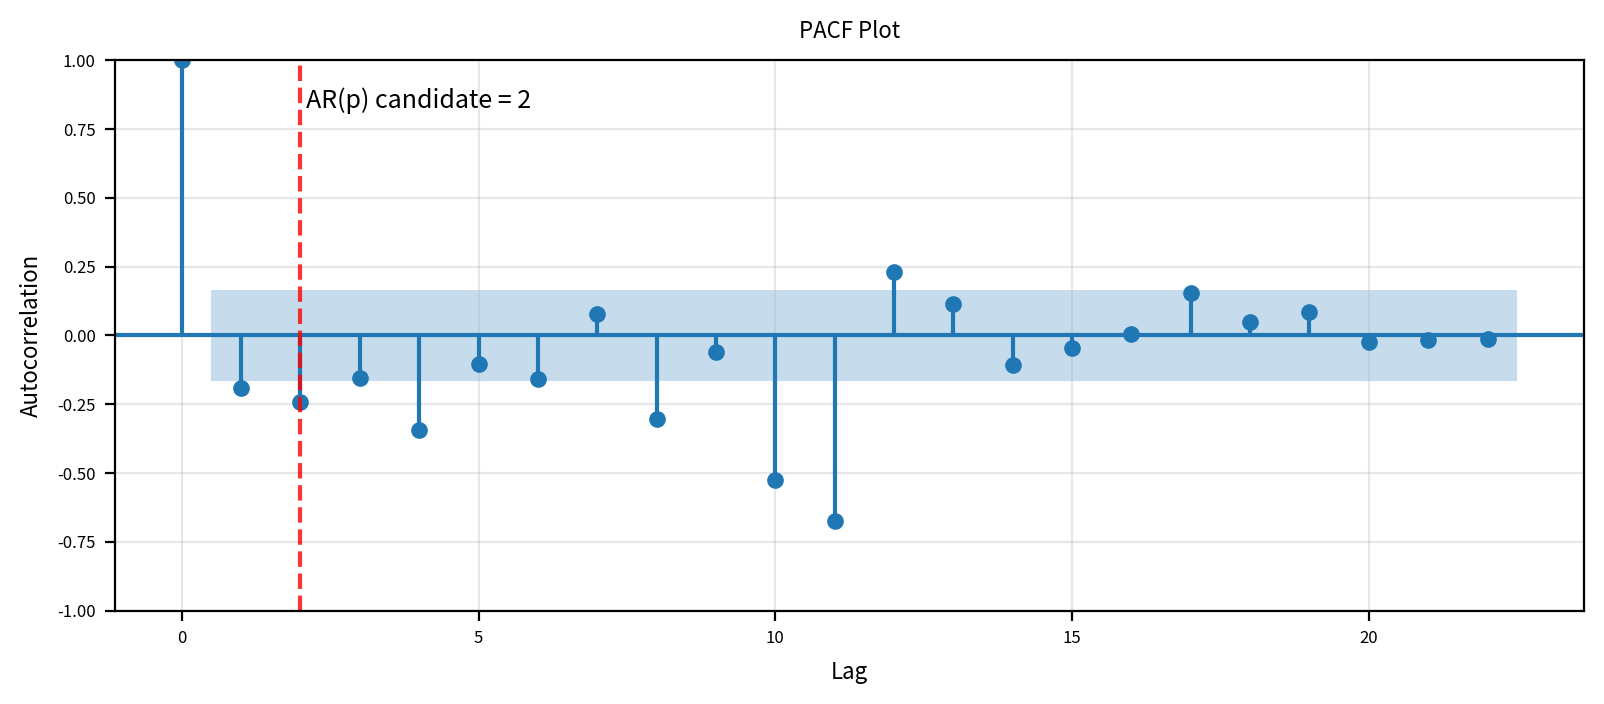

In [19]:
# 1. 그래프 초기화
width_px = 1600
height_px = 700
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2-1. PACF plot 그리기 (ax 파라미터 필수!!)
plot_pacf(diff_df['Passengers'], ax=ax)

# 2-2. 추정 AR(p) 시각화
ax.axvline(
    x = p_candidate,
    linestyle = "--",
    linewidth = 1.5,
    alpha = 0.8,
    color = 'red'
)

ax.text(
    p_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"AR(p) candidate = {p_candidate}",
    fontsize = 9,
    verticalalignment = 'top'
)

# 3. 꾸미기
ax.set_title("PACF Plot", fontsize=8, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)    # 배경 격자

# 4. 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프화면 출력
plt.close()                 # 그래프작업 종료

## #04. 추정값 결과 판정

### 1. ACF / PACF를 이용한 모형 판정 기준


### 2. 왜 ACF와 PACF를 함께 보는가


### 3. ACF, PACF 추정값에서 뽑아낸 p, d, q 값 중 최종 최적 조합 찾기

```
for i in range(0, p+1):
    for j in range(0, q+1):
        ARIMA(i, 2, j)
```

혹은
```
for d in [1, 2]:
    for i in range(0, p+1):
        for j in range(0, q+1):
            ARIMA(i, d, j)
```